<center>

# Trabajo Práctico 1: estimación de ruido y denoising

## Procesamiento Avanzado de Imágenes en Biomedicina y Biología

### Segundo Cuatrimestre 2024

<table>
      <tr>
        <th>Alumnos</th>
        <th>Legajos</th>
      </tr>
      <tr>
        <td>
          Bajlec Ivo 62175<br>
          Grau Gonzalo Andrés 62259<br>
          Neira Lucas Matias 61570
        </td>
        <td>
          62175<br>
          62259<br>
          61750<br>
        </td>
      </tr>
    </table>

**Docente**: Roberto Sebastián Tomás

**Fecha de entrega**: 02/09/2024

</center>



In [5]:
# Imports necesarios para el resto del archivo
import matplotlib.pyplot as plt
import numpy as np
import cv2
from fft_analysis import *
from snr_estimation import *
from img_roi_analyzer import *
from stat_noise_estimation import *
from test_wavelet import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objetivos del trabajo
Mediante el siguiente trabajo, se buscará mejorar la calidad de imágenes biomédicas inherentemente ruidosas. Para ello, se aplicarán técnicas de estimación de ruido y denoising, incluyendo estimaciones estadísticas a partir de regiones de interés homogéneas (ROI, por la sigla en inglés *region of interest*), análisis en el dominio frecuencial, y descomposición por transformadas de wavelets. Luego, se evaluarán los resultados obtenidos mediante métricas relacionadas al *signal to noise ratio* (SNR) de las reconstrucciones. 

## Aclaración sobre el formato del informe

Debido a que dedicamos archivos .py y .ipynb específicos para cada subítem del trabajo, para mayor modularización y prolijidad, optamos por no incluir gran parte del código fuente en el informe. En todo momento, se hará referencia a los archivos utilizados para generar las figuras, los cuales están disponibles en el repositorio de este informe. 

## Primera parte: análisis y reconstrucción de ruido mediante procesamiento de ROIs

En la siguiente sección, se desarrollará un análisis de las imágenes contenidas en la carpeta PAIByB-1, muestreando adecuadamente sus segmentos ruidosos.

#### 1.1, 1.2: Escriban un código en Python que les permita trazar una linea y un rectángulo de dimensiones BxH en diferentes porciones de en una imagen, calcule histograma, varianza y valor esperado de las imágenes obtenidas en el inciso anterior, y guarde los resultados.

Para esta parte del proyecto, se desarrolló una interfaz gráfica con PyQT6 que permite escoger una imagen desde un directorio indicado por el usuario, seleccionar una ROI en forma de línea o de rectángulo. A partir de esto, se puede visualizar el perfil de la imágen como una señal de intensidad vs. distancia en pixeles (promediando por sobre las filas para el caso de la ROI rectangular). Finalmente, se procede a guardar en un archivo dedicado (dentro de la carpeta `infosaves`, con la extesión `.json`) los siguientes valores:
- Media de intensidad de gris en la ROI
- Forma y ubicación de la ROI seleccionada
- Desviación estándar
- Nombre de la imagen de proveniencia

Al mismo tiempo, se guardó un histograma calculado por sobre las intensidades de grisis en el segmento, en formato `.csv`

![image.png](imagenes_informe/foto_gui.png)

Para acceder al código fuente, ver el archivo `img_roi_analyzer.py`


#### 1.3: Reconstrucción de ruido en base a análisis estadístico de segmentos

Haciendo uso de las características extraídas con la GUI del ítem anterior, se intentó reconstruir el ruido de las imágenes de la carpeta `PAIByB-1` mediante el análisis estadístico de ROI seleccionadas manualmente. Las funciones para realizar este análisis se encuentran en el archivo `stat_noise_estimation.py`, y las estimaciones sobre las imágenes de `PAIByB-1` se encuentran en el notebook `a01_stat_estimation.ipynb`. 

A continuación, se procede a visualizar las estimaciones obtenidas mediante análisis de media y varianza, simulando al ruido mediante un distribución normal:

In [6]:
def multi_image_comp_plot(original_img_dir: str, reconstructed_img_dir: str) -> None:
    """
    Plots original images against reconstruted ones, 
    Args:
        dir_original (str): path for original images
        dir_reconstructed (str): path for reconstructions
    """
    original_files = os.listdir(original_img_dir)
    reconstructed_files = os.listdir(reconstructed_img_dir)

    original_rec_dict = {original_file: reconstructed_file for original_file in original_files
                         for reconstructed_file in reconstructed_files
                         if original_file.split('.')[0] in reconstructed_file}

    fig, axs = plt.subplots(len(original_files), 2, figsize=(10, 20))
    i = 0

    for original, reconstructed in original_rec_dict.items():
        print(f"Noise estimation for {original}")
        img_original = cv2.imread(os.path.join(original_img_dir, original), cv2.IMREAD_GRAYSCALE)
        img_reconstructed = cv2.imread(os.path.join(reconstructed_img_dir, reconstructed), cv2.IMREAD_GRAYSCALE)
 
        axs[i, 0].imshow(img_original, cmap='gray', vmin=0, vmax=255)
        axs[i, 0].set_title(f'Original Image {original}')
        axs[i, 1].imshow(img_reconstructed, cmap='gray', vmin=0, vmax=255)
        axs[i, 1].set_title(f'Reconstructed')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

        i += 1

    plt.axis('off')
    plt.show()

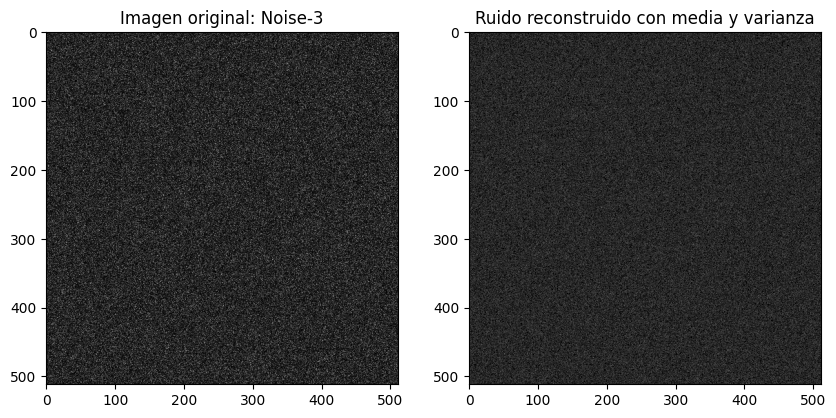

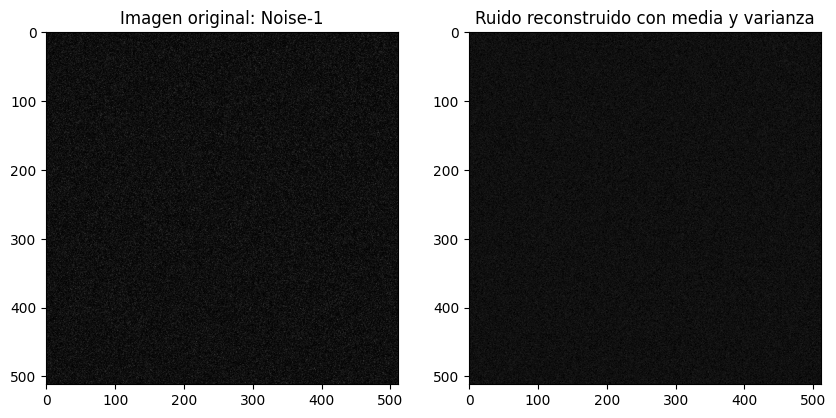

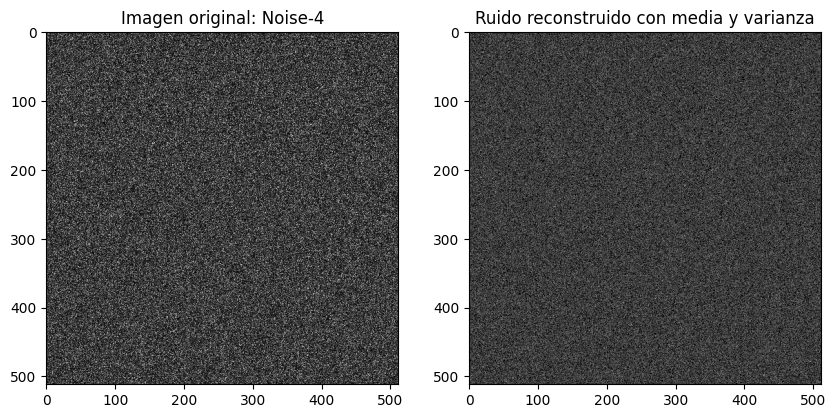

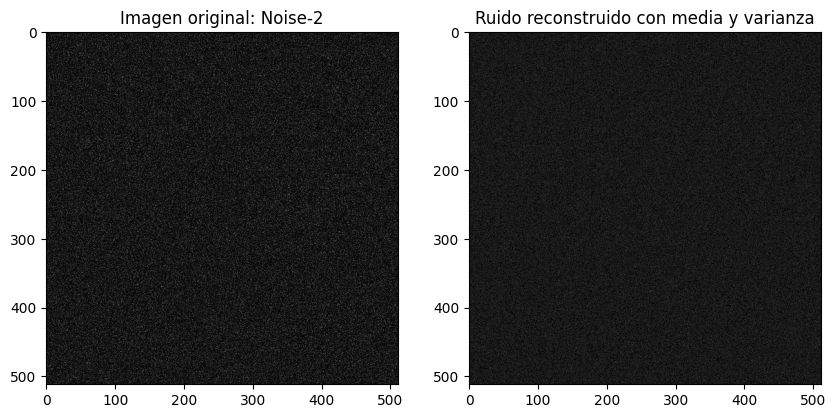

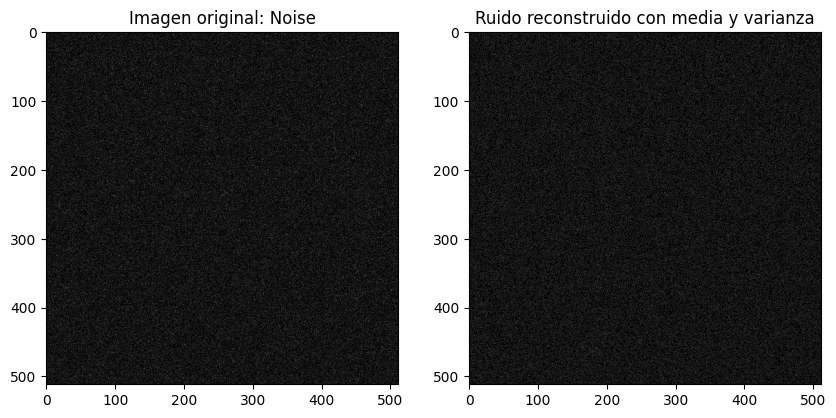

In [7]:
# Recolectamos la información de las slices obtenidas con la GUI
datadir = 'infosaves'
data_dict, hist_dict = load_stat_data(datadir)

# Estimamos el ruido
noise_dir = 'PAIByB-1'
output_dir = 'noise_estimation/stat_estimation'

stat_noise_reconstruction(data_dict, noise_dir, output_dir)

Luego, mediante análisis del histograma, se ajustó una distribución normal a cada figuras:

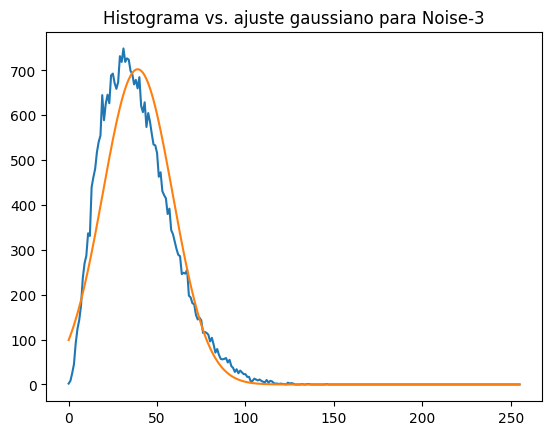

DMA=15.758


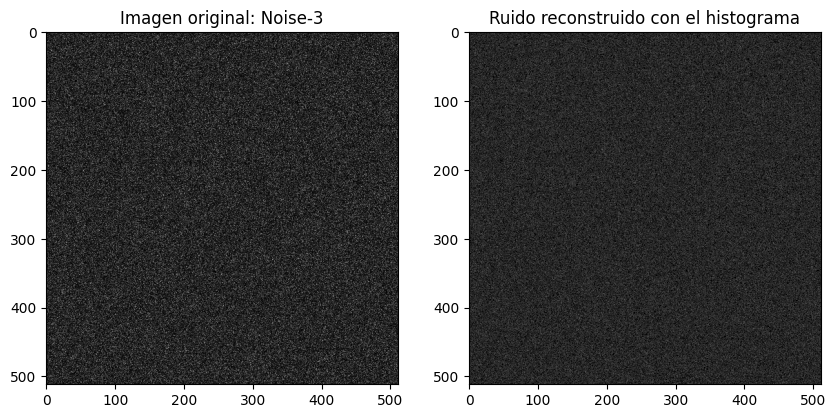

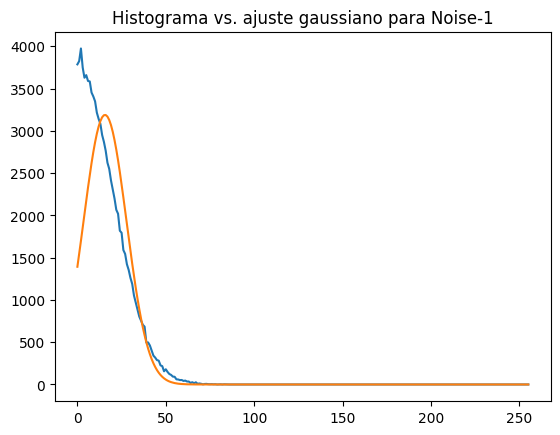

DMA=9.724


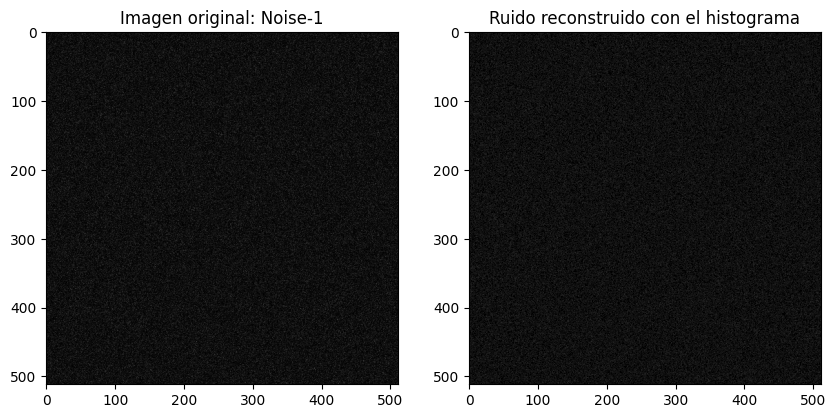

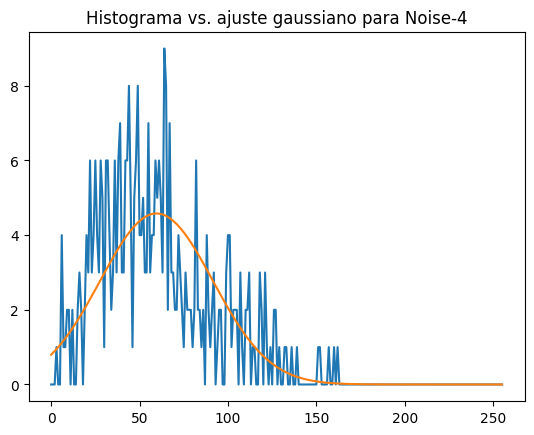

DMA=25.294


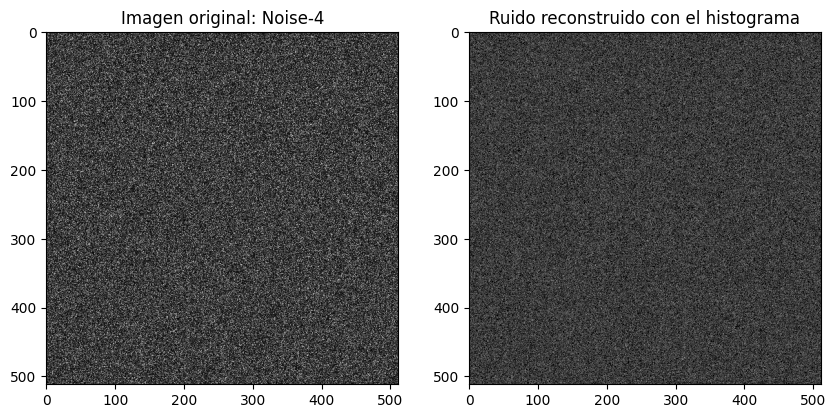

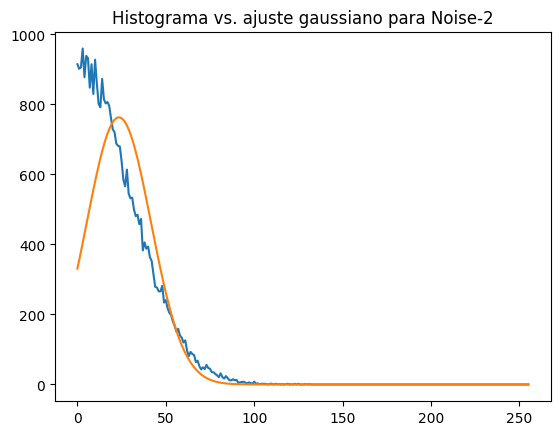

DMA=14.517


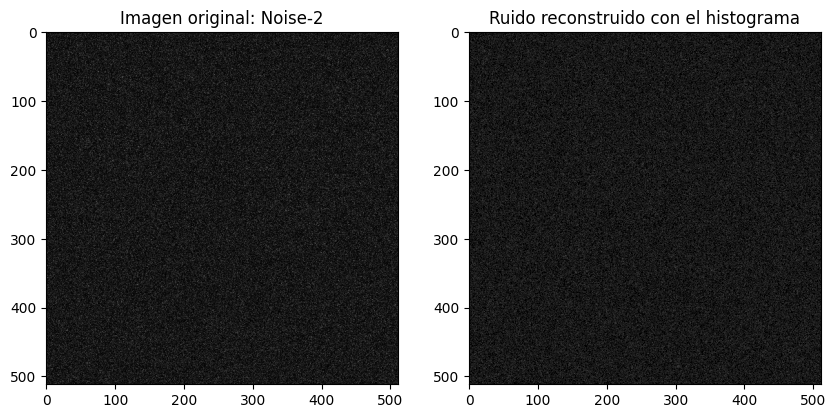

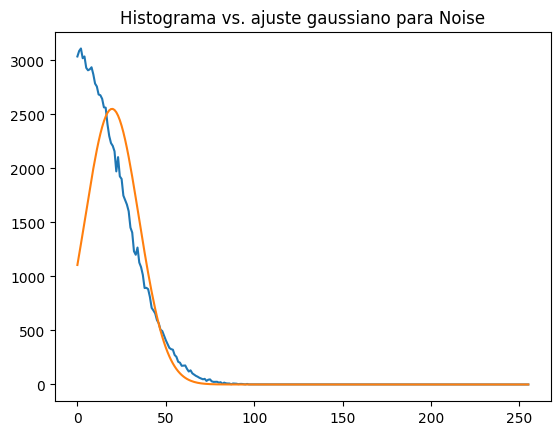

DMA=12.140


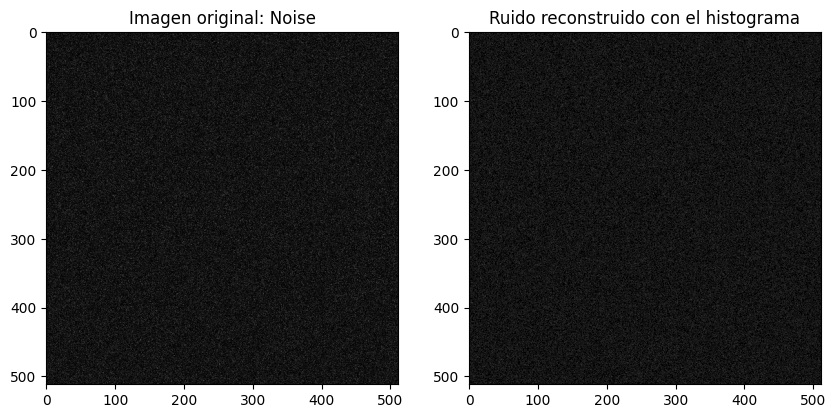

In [8]:
output_dir = 'noise_estimation/hist_estimation'
hist_noise_reconstruction(hist_dict, noise_dir, output_dir)

#### 1.4 Análisis de ruido a través de la Transformada de Fourier en 2D

Para la estimación de ruido, en primer lugar se llevará a cabo un análisis de la magnitud espectral de dos imágenes de `PAIByB-1` para una mejor lectura del NB. En particular, se trabajará con `Noise-1.tif` y`Noise-4.tif`. La magnitud espectral se analizará con imágenes en 2 y 3 dimensiones para una mejor compresión. Esto es con el fin de poder comparar la 'altura' del nivel de ruido entre `Noise-1.tif` y`Noise-4.tif`.

![alt text](noise_estimation/fourier_estimation/Noise-1_fourier.png)

![alt text](noise_estimation/fourier_estimation/Noise-4_fourier.png)

Comparando la magnitud de cada imagen, se puede decir que el ruido de `Noise-1.tif` está en el orden de 80 db como máximo, mientras que para `Noise-4.tif` el ruido se encuentra en el orden de más de 90 dB como máximo. Observando las imagenes, claramente hay una correlación entre la cantidad de ruido en cada una y su magnitud espectral, siendo mayor en el caso de `Noise-4.tif`.

#### 1.5: estimación de ruido con Wavelets



Para la estimación de ruido mediante la descomposición de wavelet, se optó por realizar una recomposiscion de la imagen mediante las componentes de ruido de alta frecuencia. 
Esto se logra seleccionando un nivel de descomposición y luego una vez obtenidos todos los componentes de ese nivel, se modifica a 0 el componente de baja frecuencia. Así la imagen reconstruida
es una combinancion del ruido de alta frecuencia.

![alt text](noise_estimation/wavelet_estimation/Noise-1_wavelet.png)

![alt text](noise_estimation/wavelet_estimation/Noise-2_wavelet.png)

![alt text](noise_estimation/wavelet_estimation/Noise-3_wavelet.png)

![alt text](noise_estimation/wavelet_estimation/Noise-4_wavelet.png)

#### 1.6: Cuantificación del denoising

Para cuantificar la eficiencia del denoising, se calcularon el peak-SNR y el SSIM. Estas funciones fueron implementadas en `snr_estimation.py`, utilizando la implementación de SSIM disponible en scikit-image

## Segunda parte: denoising aplicado a imágenes biomédicas

En esta sección, utilizaremos estimaciones del ruido en las imágenes de la carpeta PAIByB-2 para poder así extraer estas componentes y conservar únicamente la información relevante

#### 2.3.1 Estimación de ruido y denoising a través de la Transformada de Fourier en 2D

Para la estimación de ruido, en primer lugar se llevará a cabo un análisis de la magnitud espectral de dos imágenes de `PAIByB-2` para una mejor lectura del NB. En particular, se trabajará con `Pie2-1.tif` y`Pie2-4.tif`. La magnitud espectral se analizará con imágenes en 2 y 3 dimensiones para una mejor compresión. Esto es con el fin de poder comparar la 'altura' del nivel de ruido entre `Pie2-1.tif` y `Pie2-4.tif`.

![alt text](noise_estimation/fourier_estimation/Pie2-1_sp.png)

![alt text](noise_estimation/fourier_estimation/Pie2-4_sp.png)

Observando los gráficos en 3D, es posible observar que existe un aumento de la magnitud espectral para bajas frecuencias. Comparando la magnitud de las altas frecuencias entre `Pie2-1.tif` y `Pie2-4.tif`, es en el caso de `Pie2-4.tif` donde el 'piso' tiene una magnitud mayor (70 y 85 dB, respectivamente). Esto quiere decir que, efectivamente, la imagen `Pie2-4.tif` es más ruidosa que `Pie2-1.tif`.

Ahora bien, para llevar a cabo el denoising de las imágenes, decidimos aplicar *máscaras*, matrices con valores 0 y 1, las cuales, multiplicadas a la FFT de la imagen original, ocultan frecuencias espaciales características que, a la hora de reconstruir la FFT, se observen cambios en imagen.

La intención de construir estas máscaras es separar el ruido de los objetos de interés. Para crear estas máscaras, se parte de la magnitud espectral de cada imagen y se eligen dos valores umbrales, uno superior y otro inferior. El umbral inferior corresponderá a la magnitud que comparte el ruido de alta frecuencia; el umbral superior corresponderá a la magnitud que comparte el ruido de baja frecuencia.

Para `Pie2-1.tif`:
- Umbral inferior: 60 dB
- Umbral superior: 130 dB

Para `Pie2-4.tif`:
- Umbral inferior: 85 dB
- Umbral superior: 135 dB

![alt text](noise_estimation/fourier_estimation/Pie2-1_fourier.png)

![alt text](noise_estimation/fourier_estimation/Pie2-4_fourier.png)

Cada una de los figuras anteriores muestra el ruido estimado para cada imagen. Está claro nuevamente que, la imagen `Pie2-4.tif` posee mayor cantidad de ruido que `Pie2-1.tif`

Una vez determinados los umbrales para cada imagen, se aplica una máscara inversa a la creada anteriormente: nuestro algoritmo de denoising crea una máscara para ocultar el ruido de baja y alta frecuencia y conservar las frecuencias pertenecientes al objeto en estudio. Los resultados son los siguientes:

- Imagen `Pie2-1.tif` filtrada:

![alt text](denoised_img/fourier_denoising/Pie2-1_fourier.png)

- Imagen `Pie2-4.tif` filtrada:

![alt text](denoised_img/fourier_denoising/Pie2-4_fourier.png)

Luego de aplicar el denoising, la imagen resultante posee una mejora considerable con respecto a su imagen original. 

#### 2.3.2 Estimación de ruido y denoising a través de la Transformada de Wavelets en 2D

Para la reacilación de la estimación de ruido del ruido de los archivos de la carpeta `PAIByB-2` se realizó un procedimiento analogo al del punto 1.5. Extrayendo solo las comonetes de ruido de alta frecuencia. Sin, embargo aqui se puede ver que wavelets, no es un método presiso para la estimación del ruido.Esto se debe a que al querer estimarlo sin contexto sobre la imagen, se pueden también tomar los detalles de alta freciuencia como lo son los bordes de la imagen. Se podría realizar un analisis de varios niveles, sin embargo siempre se arrastra algo de los componentes de borde.

![alt text](noise_estimation/wavelet_estimation/Pie2-2_wavelet.png)

![alt text](noise_estimation/wavelet_estimation/Pie2-4_wavelet.png)

![alt text](noise_estimation/wavelet_estimation/Pie2-5_wavelet.png)

Para lo que es el denoising, se realizó una técnica similar a la estimación del ruido. Lo que se hizo fue poder seleccionar que componentes de alta frecuencia tomar además del de baja frecuencia. De esta forma, se pueden eliminar cada componente de un nivel particular. Este procedimiento es usuario dependiente,  recae en prueba y error, ya que se debe seleccionar el nivel y el componente a incluir.Para las imagenes a continuación se presenta la descomposición en 2 niveles tomando la componente de baja frecuencia y las componentes de alta frecuencia del nivel 1.

![alt text](denoised_img\wavelet_denoising\Pie2-1_wavelet.png)

![alt text](denoised_img\wavelet_denoising/Pie2-2_wavelet.png)

![alt text](denoised_img\wavelet_denoising/Pie2-3_wavelet.png)

![alt text](denoised_img\wavelet_denoising/Pie2-4_wavelet.png)

![alt text](denoised_img\wavelet_denoising/Pie2-5_wavelet.png)